# DSC 180B CNN Prototype

### Data Loading and Getting the Labels

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import torch
from PIL import Image
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from torchvision import models
import torch.nn as nn
import shutil

In [4]:
df = pd.read_csv('/content/drive/MyDrive/data/X-Ray Data/Data_Entry_2017.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00027452_000.png,Infiltration,0,27452,26,M,PA,2992,2991,0.143,0.143,NaN
1,00009644_028.png,No Finding,28,9644,74,M,AP,2048,2500,0.168,0.168,NaN
2,00016607_032.png,No Finding,32,16607,64,M,AP,2500,2048,0.168,0.168,NaN
3,00014022_063.png,No Finding,63,14022,66,M,AP,2500,2048,0.168,0.168,NaN
4,00013392_001.png,Effusion,1,13392,44,F,PA,2992,2991,0.143,0.143,NaN


In [5]:
def get_label(row):
    if 'No Finding' in row['Finding Labels']:
        return 0
    return 1

In [6]:
df['Finding Labels'] = df.apply(lambda row: get_label(row), axis=1)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00027452_000.png,1,0,27452,26,M,PA,2992,2991,0.143,0.143,NaN
1,00009644_028.png,0,28,9644,74,M,AP,2048,2500,0.168,0.168,NaN
2,00016607_032.png,0,32,16607,64,M,AP,2500,2048,0.168,0.168,NaN
3,00014022_063.png,0,63,14022,66,M,AP,2500,2048,0.168,0.168,NaN
4,00013392_001.png,1,1,13392,44,F,PA,2992,2991,0.143,0.143,NaN


In [17]:
# Create a directory to store the downloaded images
download_dir = "/content/downloaded_images"
os.makedirs(download_dir, exist_ok=True)

# Iterate through the dataframe and download the images
image_paths = df['Image Index']
for image_name in image_paths:
  source_path = '/content/drive/MyDrive/data/X-Ray Data/' + image_name
  destination_path = os.path.join(download_dir, image_name)
  try:
    print("Found Image")
    shutil.copy2(source_path, destination_path) # copy2 preserves metadata
  except FileNotFoundError:
    print(f"Image not found: {image_name}")
  except Exception as e:
    print(f"Error copying {image_name}: {e}")



print(f"Images downloaded to: {download_dir}")

Streaming output truncated to the last 5000 lines.
Found Image
Found Image
Found Image
Image not found: 00026889_002.png
Found Image
Image not found: 00025825_003.png
Found Image
Image not found: 00025495_005.png
Found Image
Image not found: 00023176_016.png
Found Image
Image not found: 00013594_036.png
Found Image
Image not found: 00020476_000.png
Found Image
Image not found: 00028902_001.png
Found Image
Image not found: 00028436_000.png
Found Image
Found Image
Image not found: 00017247_004.png
Found Image
Found Image
Image not found: 00007034_061.png
Found Image
Image not found: 00020408_010.png
Found Image
Image not found: 00018541_005.png
Found Image
Image not found: 00015246_000.png
Found Image
Image not found: 00007046_006.png
Found Image
Image not found: 00025621_007.png
Found Image
Found Image
Image not found: 00016104_000.png
Found Image
Image not found: 00029460_000.png
Found Image
Image not found: 00022899_014.png
Found Image
Image not found: 00012894_000.png
Found Image
Ima

KeyboardInterrupt: 

In [47]:
# prompt: split data from download_images into training and validation sets

# Assuming 'download_dir' and 'df' are defined as in the previous code

# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) # Adjust test_size as needed

# Create directories for training and validation images
train_dir = "/content/train_images"
val_dir = "/content/val_images"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to copy images to respective directories
def copy_images(df, destination_dir):
    for image_name in df['Image Index']:
        source_path = os.path.join(download_dir, image_name)
        destination_path = os.path.join(destination_dir, image_name)
        try:
            shutil.copy2(source_path, destination_path)
        except FileNotFoundError:
            print(f"Image not found: {image_name}")
        except Exception as e:
            print(f"Error copying {image_name}: {e}")

# Copy training images
copy_images(train_df, train_dir)
print(f"Training images copied to: {train_dir}")

# Copy validation images
copy_images(val_df, val_dir)
print(f"Validation images copied to: {val_dir}")


Streaming output truncated to the last 5000 lines.
Image not found: 00003851_002.png
Image not found: 00026604_002.png
Image not found: 00013591_002.png
Image not found: 00000017_000.png
Image not found: 00010092_011.png
Image not found: 00001473_000.png
Image not found: 00015501_000.png
Image not found: 00017430_005.png
Image not found: 00000766_014.png
Image not found: 00008613_006.png
Image not found: 00000831_005.png
Image not found: 00030720_003.png
Image not found: 00002524_023.png
Image not found: 00006271_082.png
Image not found: 00006604_000.png
Image not found: 00022207_000.png
Image not found: 00019242_013.png
Image not found: 00014653_002.png
Image not found: 00029385_001.png
Image not found: 00029532_000.png
Image not found: 00027464_000.png
Image not found: 00002685_001.png
Image not found: 00012874_001.png
Image not found: 00003392_022.png
Image not found: 00006363_000.png
Image not found: 00016377_003.png
Image not found: 00017051_003.png
Image not found: 00008462_003.p

In [81]:
def normalize_image(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Scale to [0,1]
    img = (img * 255).astype(np.uint8)  # Convert to uint8
    return img

def apply_clahe(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

def resize_image(img, target_size=(224, 224)):
    return cv2.resize(img, target_size)

def convert_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def add_random_rotation(img, max_angle=5):
    angle = np.random.uniform(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

In [82]:
X = []
y = []

# load png images into X and y
for i in range(len(df)):
    image_name = df['Image Index'][i]
    png_path = os.path.join('/content/downloaded_images', image_name) # Use os.path.join to create the path

    # Check if the file exists before trying to read it
    if not os.path.exists(png_path):
        print(f"Image file not found: {png_path}")
        continue

    print("Image found")

    img = cv2.imread(png_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Failed to load image: {png_path}")
        continue

    img = resize_image(img)
    img = normalize_image(img)
    img = apply_clahe(img)
    img = convert_to_rgb(img)
    img = add_random_rotation(img)

    X.append(img)
    y.append(df['Finding Labels'][i])

    print(len(X))
    print(len(y))

X = np.array(X)
y = np.array(y)

Streaming output truncated to the last 5000 lines.
Image file not found: /content/downloaded_images/00016434_010.png
Image file not found: /content/downloaded_images/00010406_006.png
Image file not found: /content/downloaded_images/00030272_000.png
Image file not found: /content/downloaded_images/00024188_000.png
Image file not found: /content/downloaded_images/00003814_001.png
Image file not found: /content/downloaded_images/00023870_000.png
Image file not found: /content/downloaded_images/00022155_005.png
Image file not found: /content/downloaded_images/00003900_000.png
Image file not found: /content/downloaded_images/00013321_000.png
Image file not found: /content/downloaded_images/00018237_026.png
Image file not found: /content/downloaded_images/00017514_001.png
Image file not found: /content/downloaded_images/00026078_005.png
Image file not found: /content/downloaded_images/00007368_000.png
Image file not found: /content/downloaded_images/00019364_002.png
Image file not found: /co

In [83]:
# Convert to tensor to be fed to ResNet50
X = torch.tensor(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5782, 224, 224, 3]),
 torch.Size([1446, 224, 224, 3]),
 (5782,),
 (1446,))

### Healthy vs Unhealthy Lung Comparison

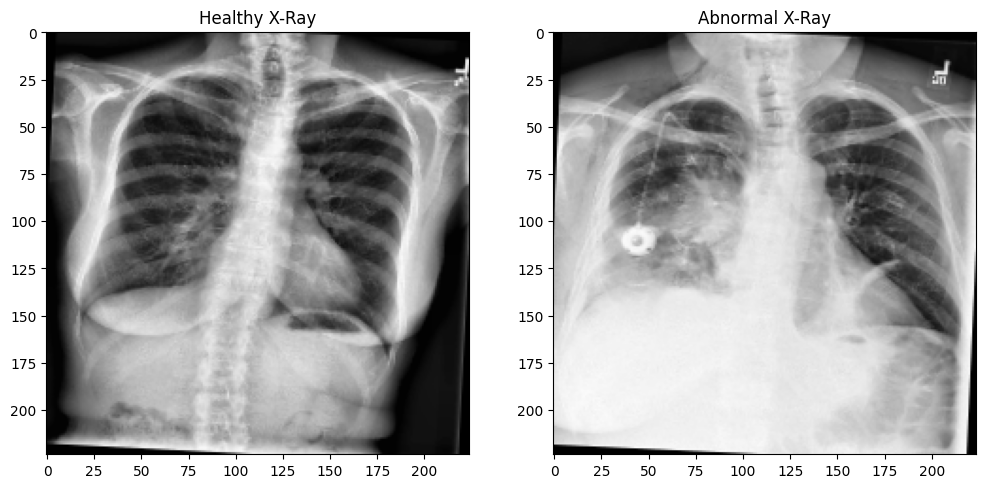

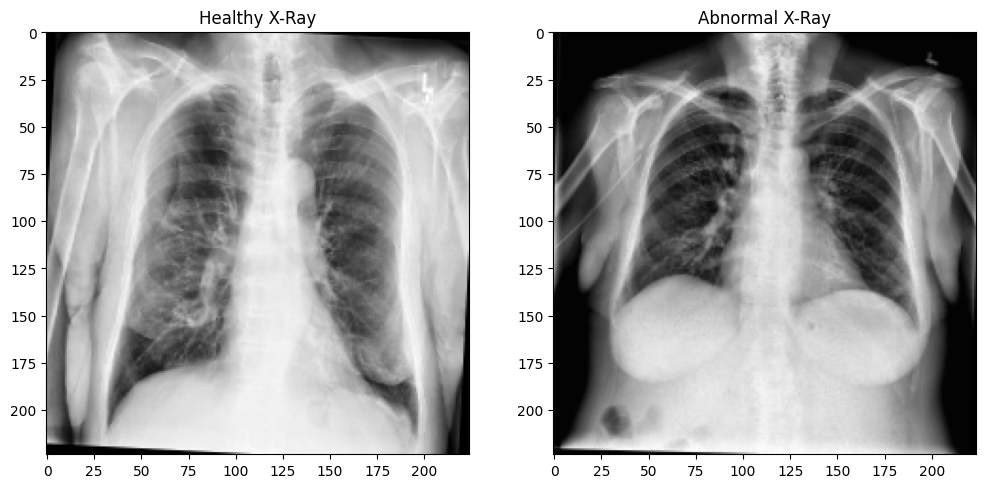

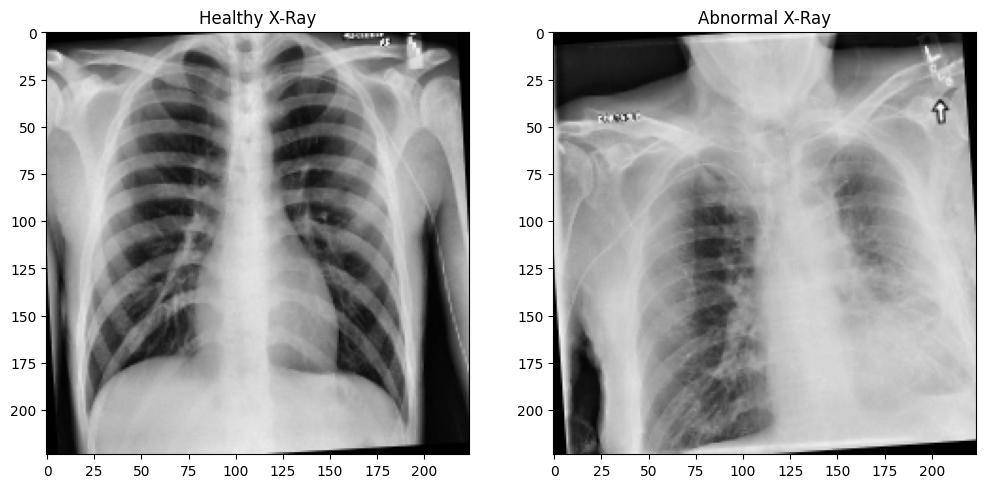

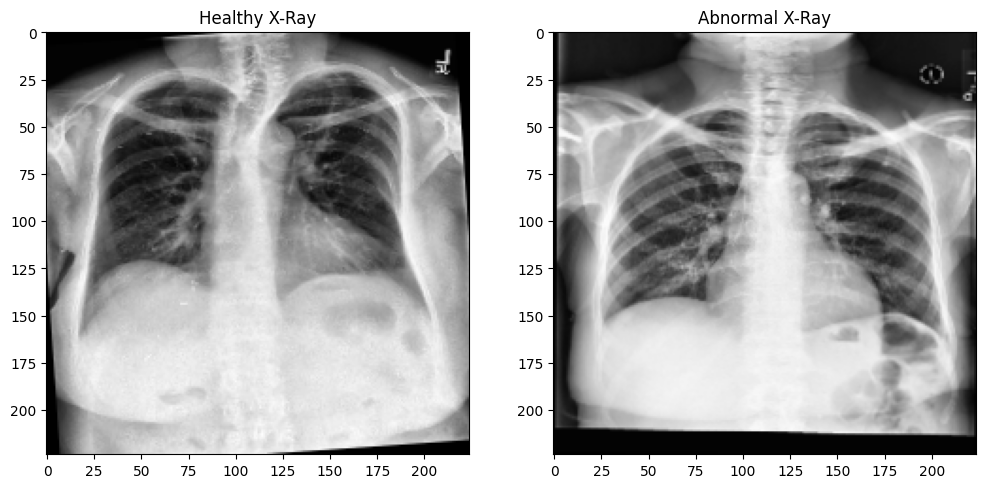

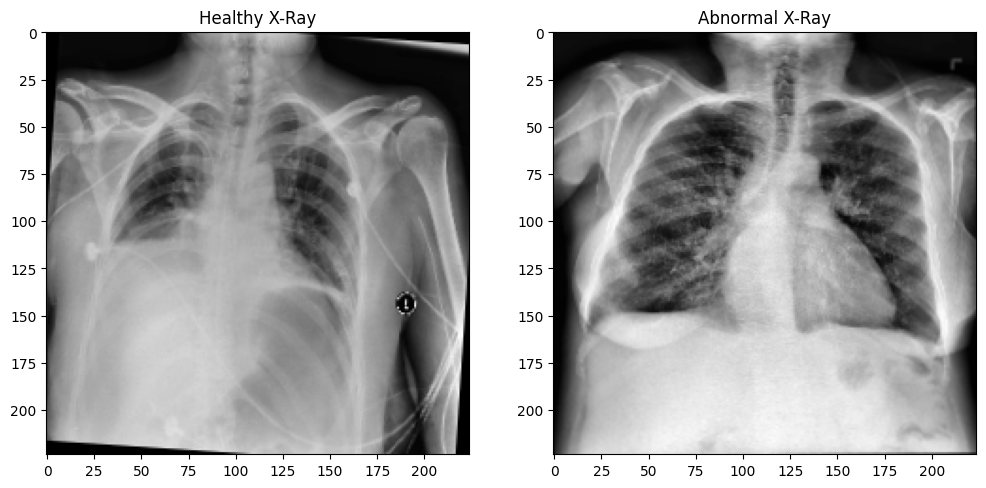

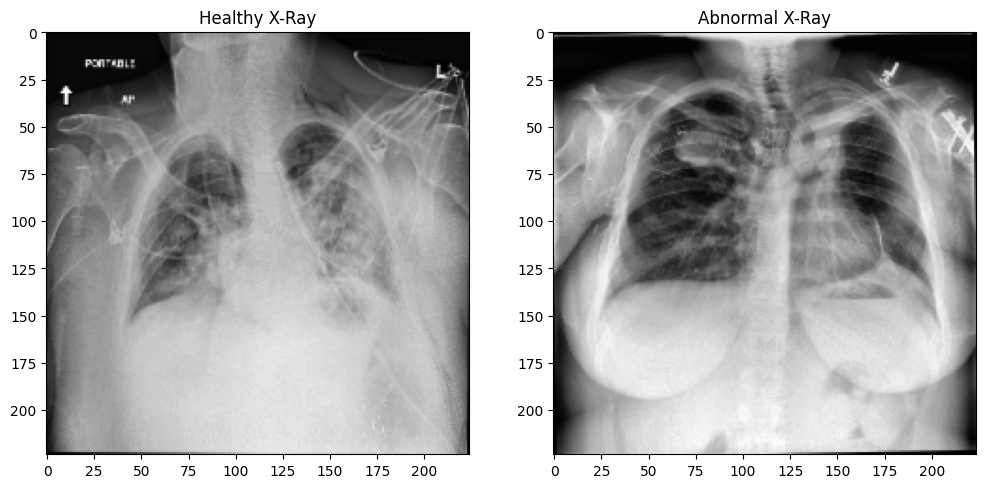

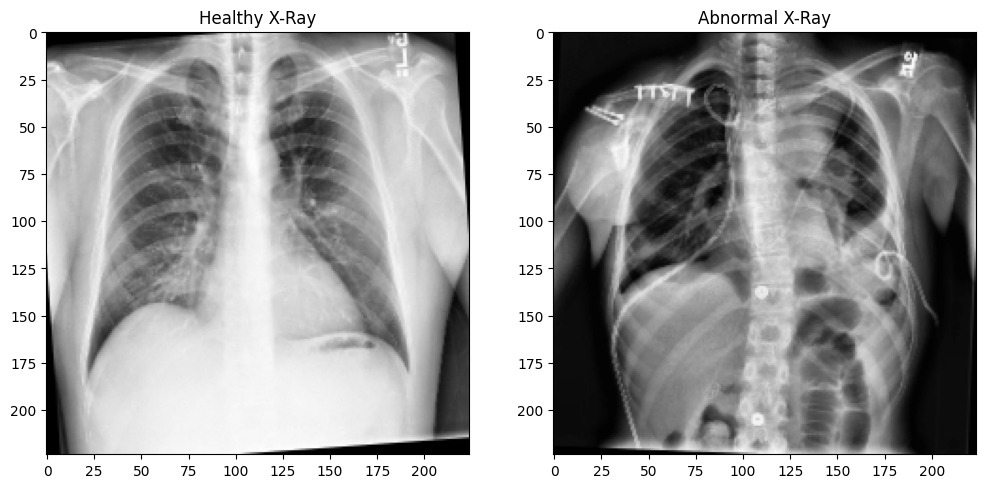

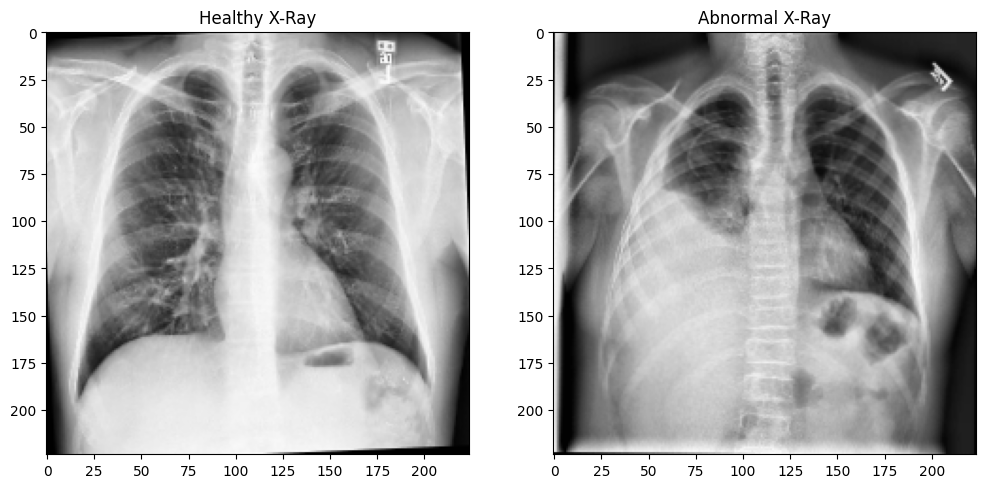

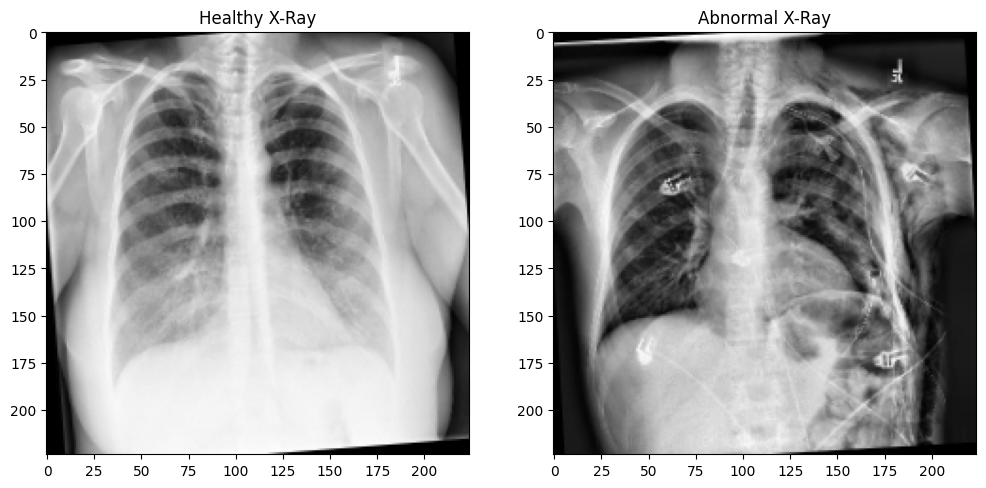

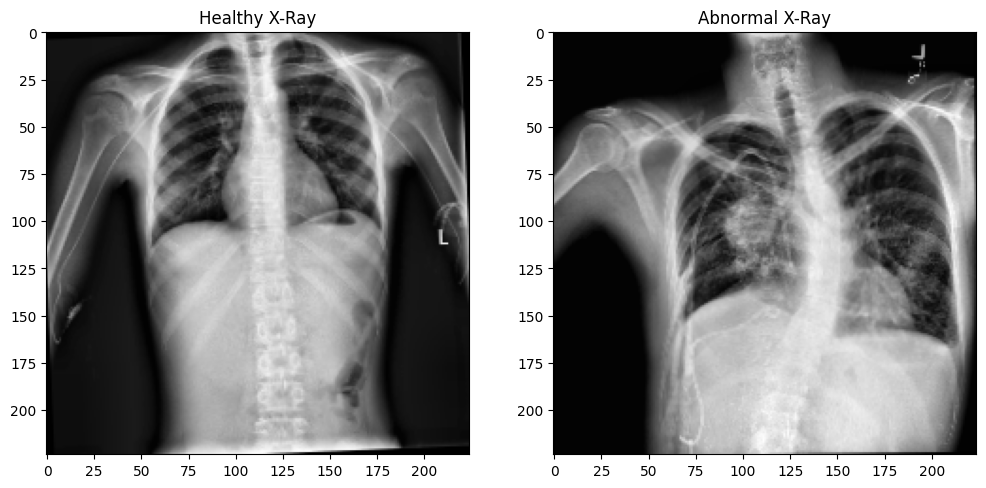

In [85]:
healthy_x_rays = []
abnormal_x_rays = []
i = 0
while len(healthy_x_rays) < 10 or len(abnormal_x_rays) < 10:
    if y_train[i] == 0:
        healthy_x_rays.append(X_train[i])
    else:
        abnormal_x_rays.append(X_train[i])
    i += 1

for i in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(healthy_x_rays[i], cmap='gray')
    ax[0].set_title('Healthy X-Ray')
    ax[1].imshow(abnormal_x_rays[i], cmap='gray')
    ax[1].set_title('Abnormal X-Ray')
    plt.show()


In [95]:
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Load ResNet50V2
resnet50 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Unfreeze deeper layers for fine-tuning
for layer in resnet50.layers[-22:]:
    layer.trainable = True

# Define the model
model = Sequential([
    resnet50,
    Flatten(),
    Dense(256, activation="relu", kernel_regularizer=l2(1e-4)), # Fixed: closing parenthesis was missing here
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# Implement Cosine Annealing
initial_lr = 1e-4
cosine_decay_restarts = CosineDecayRestarts(initial_learning_rate=initial_lr,
                                            first_decay_steps=5000,
                                            t_mul=2.0,  # Increases period after each restart
                                            m_mul=0.8,  # Reduce max learning rate after each restart
                                            alpha=1e-6)

# Compile model with Cosine Annealing scheduler
model.compile(optimizer=Adam(learning_rate=cosine_decay_restarts), # Fixed: using cosine_decay_restarts instead of cosine_decay
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=16,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5735 - loss: 0.8192
Epoch 1: val_loss improved from inf to 0.65596, saving model to best_model.keras
362/362 ━━━━━━━━━━━━━━━━━━━━ 90s 114ms/step - accuracy: 0.5736 - loss: 0.8189 - val_accuracy: 0.6653 - val_loss: 0.6560
Epoch 2/100
361/362 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6913 - loss: 0.6295
Epoch 2: val_loss did not improve from 0.65596
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6913 - loss: 0.6296 - val_accuracy: 0.6162 - val_loss: 0.8002
Epoch 3/100
361/362 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7514 - loss: 0.5559
Epoch 3: val_loss did not improve from 0.65596
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7514 - loss: 0.5560 - val_accuracy: 0.6176 - val_loss: 0.7092
Epoch 4/100
361/362 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8233 - loss: 0.4306
Epoch 4: val_loss did not improve from 0.65596
362/362 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8233 - loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       774
           1       0.62      0.73      0.67       672

    accuracy                           0.67      1446
   macro avg       0.67      0.67      0.67      1446
weighted avg       0.67      0.67      0.66      1446



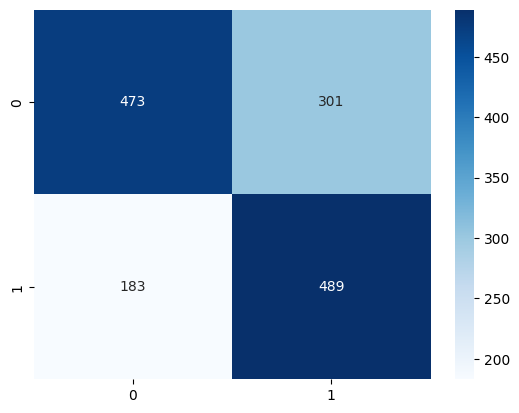

In [96]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# output precision, recall, f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))



In [97]:
# save the model as a pickle file
import pickle
with open('cnn_chest_xray_model_final.pkl', 'wb') as f:
    pickle.dump(model, f)

